In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor


from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb

## Part 1: Initialize dfs, preprocessing

### 1a. DWT_8702

In [11]:
#Part 1: initialize class, read in dataframe
prep_dwt8 = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/DWT_8702.csv') #initialize class for DWT_8702
prep_dwt8.df.head() 

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.462234,-2.390083,-2.496001,-2.567832,-2.714483,-2.853814,-2.587323,-2.815667,-2.529468,-2.487444,...,-2.947384,-2.540375,-2.616557,-2.093166,-2.868000,-2.848592,-2.804433,-2.616103,-2.390560,1
1,-2.303016,-2.243269,-2.377895,-2.322088,-2.544736,-2.664095,-2.746503,-2.766540,-2.491645,-2.554321,...,-2.927361,-2.402814,-2.416895,-2.345415,-2.815763,-2.905354,-2.957433,-2.701947,-2.344442,1
2,-2.378106,-2.286579,-2.506946,-2.477289,-2.450869,-2.848399,-2.664014,-2.799355,-2.469628,-2.653850,...,-2.909338,-2.932407,-3.013070,-2.302342,-2.872999,-2.893005,-2.884964,-2.744103,-2.603805,1
3,-2.411076,-2.357384,-2.538120,-2.373840,-2.467567,-2.738331,-2.708997,-2.620310,-2.355342,-2.769357,...,-2.929341,-3.015539,-3.008299,-2.217575,-2.847411,-2.946254,-2.969480,-2.614736,-2.401006,1
4,-2.382939,-2.423288,-2.519401,-2.333251,-2.608106,-2.718791,-2.697185,-2.802862,-2.443454,-2.765421,...,-2.822273,-2.751273,-2.699928,-2.227029,-2.842104,-2.909700,-2.976055,-2.682061,-2.421083,1


In [6]:
#Part 2: label_df() function demo
dwt8 = prep_dwt8.label_df()  #return full labeled dataframe with slope_1, slope_2, ..., slope_29, state
dwt8.head()

,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8,slope_9,slope_10,...,slope_21,slope_22,slope_23,slope_24,slope_25,slope_26,slope_27,slope_28,slope_29,state
0,-2.462234,-2.390083,-2.496001,-2.567832,-2.714483,-2.853814,-2.587323,-2.815667,-2.529468,-2.487444,...,-2.947384,-2.540375,-2.616557,-2.093166,-2.868000,-2.848592,-2.804433,-2.616103,-2.390560,1
1,-2.303016,-2.243269,-2.377895,-2.322088,-2.544736,-2.664095,-2.746503,-2.766540,-2.491645,-2.554321,...,-2.927361,-2.402814,-2.416895,-2.345415,-2.815763,-2.905354,-2.957433,-2.701947,-2.344442,1
2,-2.378106,-2.286579,-2.506946,-2.477289,-2.450869,-2.848399,-2.664014,-2.799355,-2.469628,-2.653850,...,-2.909338,-2.932407,-3.013070,-2.302342,-2.872999,-2.893005,-2.884964,-2.744103,-2.603805,1
3,-2.411076,-2.357384,-2.538120,-2.373840,-2.467567,-2.738331,-2.708997,-2.620310,-2.355342,-2.769357,...,-2.929341,-3.015539,-3.008299,-2.217575,-2.847411,-2.946254,-2.969480,-2.614736,-2.401006,1
4,-2.382939,-2.423288,-2.519401,-2.333251,-2.608106,-2.718791,-2.697185,-2.802862,-2.443454,-2.765421,...,-2.822273,-2.751273,-2.699928,-2.227029,-2.842104,-2.909700,-2.976055,-2.682061,-2.421083,1


In [8]:
#Part 3: Fisher's
dwt8_filtered = prep_dwt8.fishers() #windows with highest Fisher's criterion values + state, default 5 features
dwt8_filtered.head()

,slope_6,slope_29,slope_4,slope_11,slope_28,state
0,-2.853814,-2.390560,-2.567832,-2.409633,-2.616103,1
1,-2.664095,-2.344442,-2.322088,-2.428556,-2.701947,1
2,-2.848399,-2.603805,-2.477289,-2.089429,-2.744103,1
3,-2.738331,-2.401006,-2.373840,-1.990729,-2.614736,1
4,-2.718791,-2.421083,-2.333251,-1.712213,-2.682061,1


In [20]:
dwt8.state.value_counts() #verify number of cases and controls (162/91)

state
1    162
0     91
Name: count, dtype: int64

### 1b. WPD_Wang_8702

In [17]:
#Part 1
prep_wp8 = preprocessing(file_path = '/Users/jhbyun/Documents/685-Pr/ovarian-cancer-classification/data/WPD_Wang_8702.csv') #initialize class for DWT_8702

#Part 2
wp8 = prep_wp8.label_df()

#Part 3
wp8_filtered = prep_wp8.fishers()
wp8_filtered.head()

,slope_6,slope_27,slope_29,slope_17,slope_25,state
0,-1.947008,-1.805645,-1.521289,-1.648877,-1.908993,1
1,-1.787114,-1.857716,-1.443023,-1.771526,-1.781598,1
2,-1.935820,-1.848338,-1.619408,-1.778519,-1.853294,1
3,-1.857946,-1.857774,-1.516554,-1.685034,-1.783911,1
4,-1.834842,-1.861765,-1.478096,-1.663361,-1.813565,1


In [18]:
wp8.state.value_counts() #verify number of cases and controls (162/91)

state
1    162
0     91
Name: count, dtype: int64

In [19]:
#store dwt8 and wp8 dataframes in memory
%store -r dwt8 
%store -r wp8 

## Part 2. EDA

### 2a. Correlation Coefficient Matrix

Text(0.5, 1.0, 'Correlation Coefficient Matrix for DWT_8702')

Text(0.5, 1.0, 'Correlation Coefficient Matrix for WPD_Wang_8702')

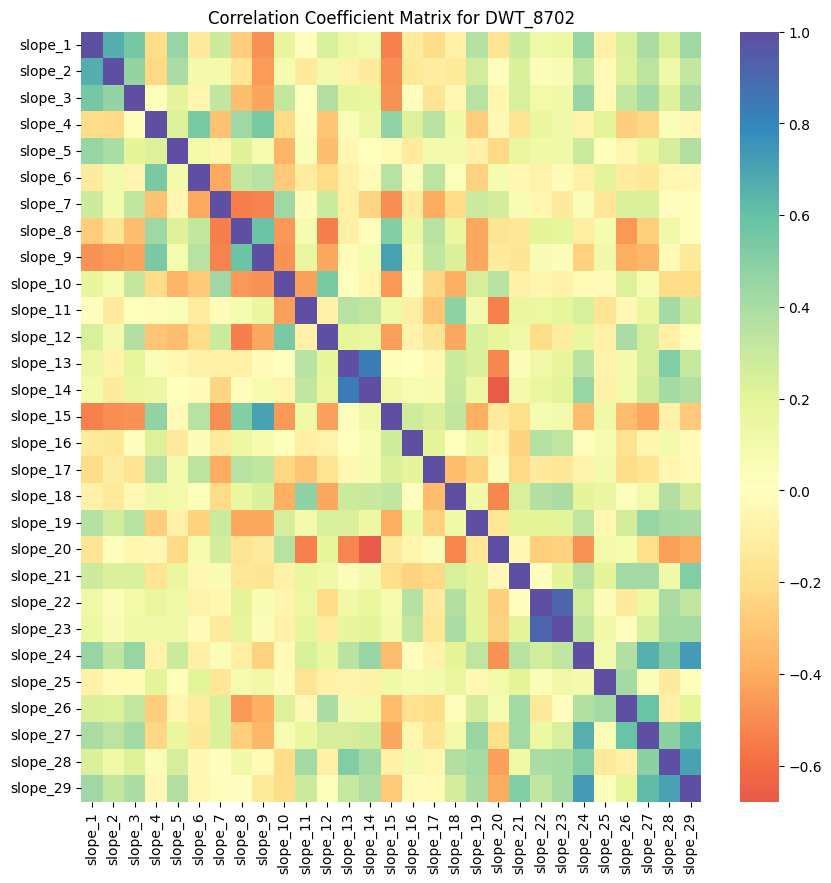

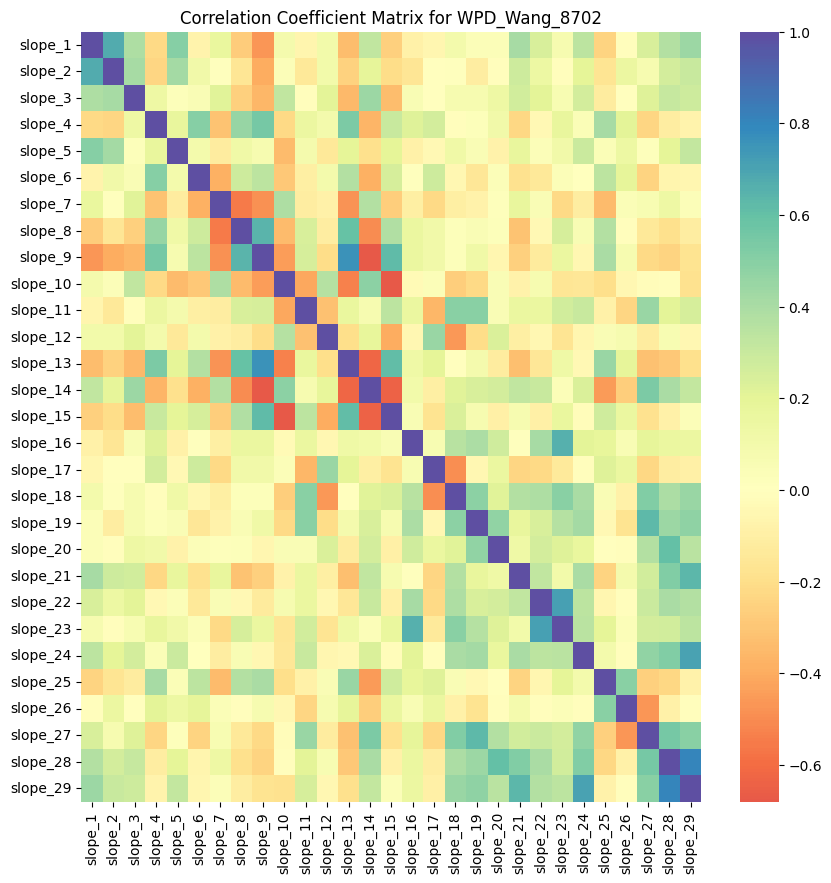

In [22]:
def corr_map(df=dwt8, file_name='DWT_8702'): #default fx runs dwt8 / DWT_8702

    df = df.loc[:, df.columns != 'state'] #remove state/supervisor column, df is features only
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 10))
    map = sns.heatmap(corr_matrix, annot=False, center=0, cmap="Spectral").set_title("Correlation Coefficient Matrix for " + file_name)
    
    return map

display(corr_map(df=dwt8, file_name='DWT_8702')) #run fx with dwt8/DWT_8702
display(corr_map(df=wp8, file_name='WPD_Wang_8702')) #run fx with wp8/WPD_Wang_8702

### 2b. Variance Inflation Factors for Multicollinearity Detection

In [23]:
df_names = {'dwt8': 'DWT_8702', 
            'wp8': 'WPD_Wang_8702'} 

def vif(dfs = [dwt8, wp8]): 

    for i, df in enumerate(dfs):
        
        df = df.loc[:, df.columns != 'state'] #remove state/supervisor column, df is features only
        
        vif_data = pd.DataFrame() #initialize dataframe for VIF values
        vif_data["feature_"+str(df_names[list(df_names.keys())[i]])] = df.columns #row for each feature
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

        print(vif_data)

vif() #demo with WPD_Wang_8702 file

   feature_DWT_8702           VIF
0           slope_1   2338.948452
1           slope_2   2000.979972
2           slope_3   3410.190752
3           slope_4   1601.611798
4           slope_5   1374.184097
5           slope_6   2429.194280
6           slope_7   2230.124306
7           slope_8   4847.224857
8           slope_9   3209.797590
9          slope_10   3184.540636
10         slope_11    506.704478
11         slope_12    707.543630
12         slope_13   1302.798094
13         slope_14   3369.523766
14         slope_15   1217.691951
15         slope_16    398.396436
16         slope_17    452.540252
17         slope_18    992.129169
18         slope_19    945.632022
19         slope_20   2858.764743
20         slope_21   2897.890262
21         slope_22   3913.411270
22         slope_23   2602.708800
23         slope_24    362.970507
24         slope_25   1769.478793
25         slope_26  14489.531778
26         slope_27   9734.227883
27         slope_28   1360.192429
28         slo